In [ ]:
!pip install sklearn
!pip install imblearn
!pip install scipy
!pip install tqdm


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn import metrics 
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy import stats
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# All Constants

In [7]:
DATA_DIR = os.path.join('..', 'data')
SNP500_COMPANIES_FILE_PATH = os.path.join(DATA_DIR, 'sp500_companies.csv')
SNP500_INDEX_FILE_PATH     = os.path.join(DATA_DIR, 'sp500_index.csv')
SNP500_STOCKS_FILE_PATH    = os.path.join(DATA_DIR, 'sp500_stocks.csv')

## Load Datasets

In [6]:
def loadDataset(paths):
    index = paths[0]    # SP_500 Index
    companies = paths[1] # SP_500 Companies
    stocks = paths[2] # SP_500 Stocks

    # Load datasets 
    index_df = pd.read_csv(index, parse_dates=['Date'])
    companies_df = pd.read_csv(companies)
    stocks_df = pd.read_csv(stocks)
    stocks_df = stocks_df[stocks_df['Close'].isnull() == False]

    # Merge datasets for training
    merged_df = stocks_df.merge(companies_df, on='Symbol', how='left')

    print(f'Shape of the merged dataset: {merged_df.shape}')

    # train test split
    train, test = train_test_split(merged_df, test_size=0.2, random_state=42)

    # Train data
    print(f'Shape of Train dataset: {train.shape}')

    # Test data
    print(f'Shape of Test dataset: {test.shape}')

    return train, test

In [8]:
file_paths = [SNP500_INDEX_FILE_PATH, SNP500_COMPANIES_FILE_PATH, SNP500_STOCKS_FILE_PATH]
stocks, stocks_test = loadDataset(file_paths)

Shape of the merged dataset: (617831, 23)
Shape of Train dataset: (494264, 23)
Shape of Test dataset: (123567, 23)


In [9]:
def selectFeatures(df):
    # Text Features
    text_features = ['Symbol','Sector']

    # Numerical Features
    num_features = ['Volume', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Weight']

    # Prepare dataset for clustering
    return text_features, num_features, df[text_features + num_features]

text_features, num_features, stocks = selectFeatures(stocks)  
stocks.head()

,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
17737,ALB,Basic Materials,2147300.0,88.65,10419920896,-9.350780e+08,-0.414,0.000187
59311,AJG,Financial Services,533600.0,283.10,70719234048,3.382200e+09,0.119,0.001272
24725,GOOG,Communication Services,136754676.0,192.96,2351623045120,1.234700e+11,0.151,0.042309
32251,AMZN,Consumer Cyclical,158006000.0,224.92,2365033807872,1.115830e+11,0.110,0.042550
246591,FAST,Industrials,2078900.0,74.82,42863333376,1.693200e+09,0.035,0.000771


## Data Preparation

#### Methods for Feature engineering

In [10]:
# Method to drop all duplicate rows
def remove_duplicates(df):
    print("Removing Duplicate Rows")
    duplicate_rows = df[df.duplicated()]
    print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
    df.drop_duplicates()
    print(f"Shape after removing duplicates: {df.shape}")
    return df

# Impute by Mean
def imputeByMean(df, feature, groupby_col):
    print("Imputing missing values by Mean")
    df[feature] = df.groupby(groupby_col)[feature].transform(lambda x: x.fillna(x.mean()))
    return df

# Impute by Linear Regression
def imputeByRegression(df, features, target):
    print("Imputing missing values by Linear Regression")
    # Prepare the DataFrame for regression
    ebitda_df = df[features + [target]]

    # df[df['Ebitda'].notnull()]
    train = ebitda_df[ebitda_df[target].notnull()]
    test = ebitda_df[ebitda_df[target].isnull()]

    model = LinearRegression()
    model.fit(train[features], train[target])

    # Predict Ebitda for stocks with missing values
    df.loc[df[target].isnull(), target] = model.predict(test[features])
    
    return df

# Log Transformation
def logTransform(df, features):
    print("Applying Log Transformation")
    for feature in features:
        df[feature] = np.log1p(df[feature])
    
    # Plot the distribution of numerical features after log transformation
    plot_feature_distribution(stocks, num_features)
    return df

# Normalize Features
def normalize(df, features):
    print("Normalizing Features")
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

# Plot the distribution of numerical features
def plot_feature_distribution(df, features):
    fig, ax = plt.subplots(2, 3, figsize=(18, 8))
    plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=1, wspace=0.4)
    ax = ax.flatten()
    for i,col in enumerate(features):
        kde = stats.gaussian_kde(stocks[col])
        x = np.linspace(stocks[col].min(), stocks[col].max(), 1000)
        ax[i].plot(x, kde(x), color='red')
        ax[i].hist(stocks[col], bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='black')
        ax[i].set_title(f'histogram for {col}')
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('Density')

In [11]:
def performFeatureEngineeing(stocks_df):
    # Drop all duplicate rows
    stocks_cleaned = remove_duplicates(stocks_df)

    # Impute revenue growth by taking a mean of revenue growth for each sector
    stocks_cleaned = imputeByMean(stocks_cleaned,
                        feature=['Revenuegrowth'],
                        groupby_col='Sector')
    
    # Impute Ebitda by regression
    stocks_cleaned = imputeByRegression(stocks_cleaned, features=['Marketcap', 'Revenuegrowth', 'Weight'], target='Ebitda')

    # Log Transform selected features
    stocks_cleaned = logTransform(stocks_cleaned, ['Volume', 'Currentprice', 'Marketcap', 'Revenuegrowth', 'Weight'])

    # Normalize numerical features
    stocks_cleaned = normalize(stocks_cleaned, num_features)

    return stocks_cleaned

Removing Duplicate Rows
Number of duplicate rows: 29671
Shape after removing duplicates: (494264, 8)
Imputing missing values by Mean
Imputing missing values by Linear Regression
Applying Log Transformation
Normalizing Features


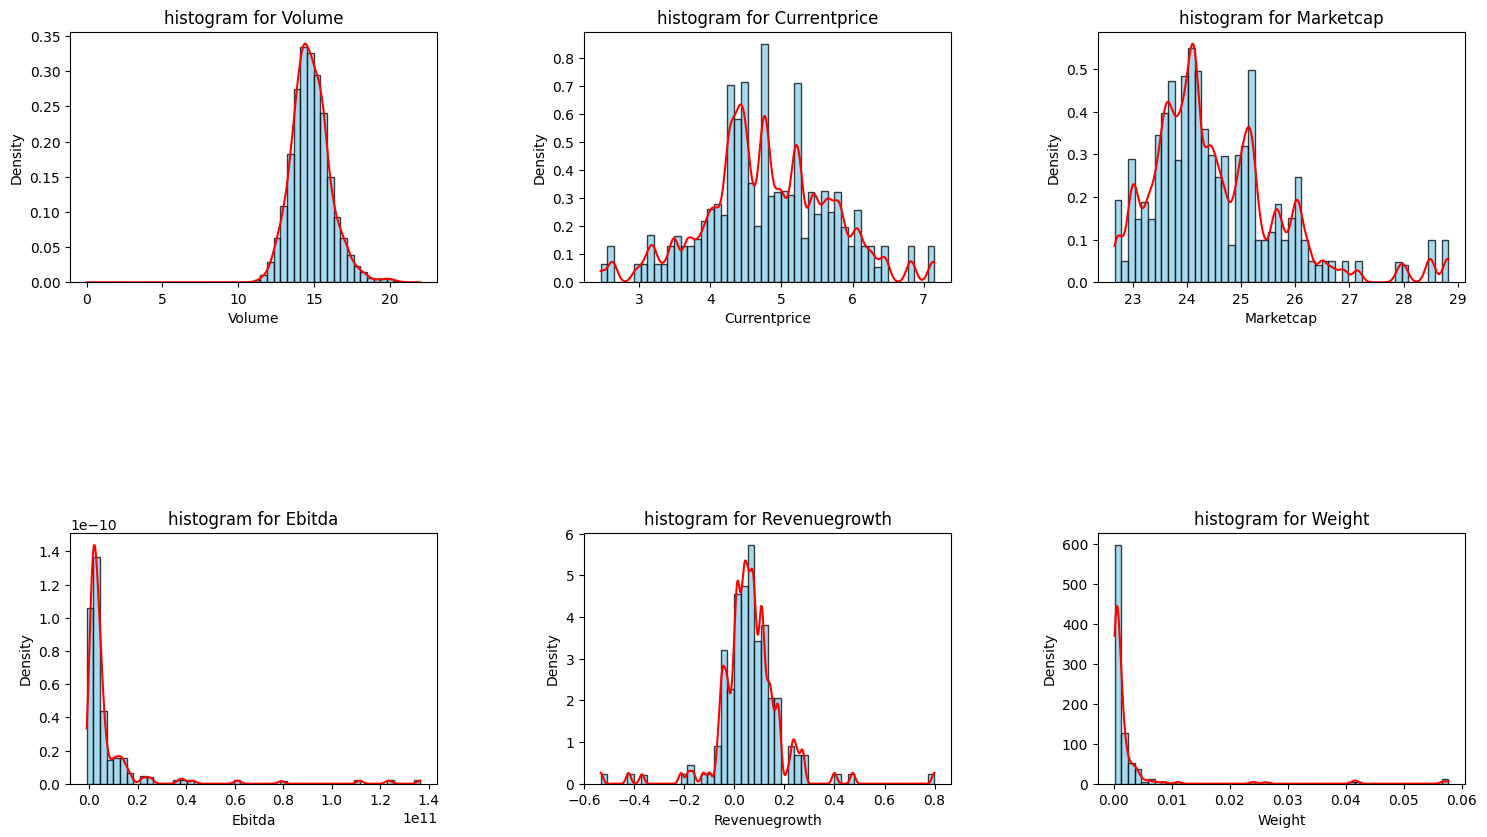

In [12]:
stocks = performFeatureEngineeing(stocks)


In [13]:

stocks.head()

,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
17737,ALB,Basic Materials,-0.169948,-0.344756,-1.229153,-0.493463,-4.601036,-0.304722
59311,AJG,Financial Services,-1.238181,0.953903,0.356761,-0.259420,0.396731,-0.169714
24725,GOOG,Communication Services,3.017120,0.524166,3.258733,6.250634,0.614573,4.832558
32251,AMZN,Consumer Cyclical,3.127942,0.695902,3.263442,5.606231,0.334340,4.861384
246591,FAST,Industrials,-0.194785,-0.533406,-0.057896,-0.350982,-0.206165,-0.232064


## Modelling 

In [14]:
# Function to perform KMeans clustering
# :param data: DataFrame containing the features for clustering
# :param n_clusters: Number of clusters to form
def kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)
    kmeans.fit(data)
    return kmeans, kmeans.labels_, kmeans.inertia_

In [16]:

inertias = []
knn_labels = []
train_eval = stocks.copy()

# Perform KMeans clustering for different values of k
for n_clusters in range(2, 8):
    kmeans, labels, inertia = kmeans_clustering(stocks[num_features], n_clusters)
    inertias.append(inertia)
    knn_labels.append(labels)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(stocks[num_features], labels)
    print(f'Number of clusters: {n_clusters}, Inertia: {inertia}, Silhouette Score: {silhouette_avg}')
    
    # Add cluster labels to the DataFrame
    stocks[f'cluster_{n_clusters}'] = labels



Number of clusters: 2, Inertia: 1838627.0440620733, Silhouette Score: 0.7394423302193157
Number of clusters: 3, Inertia: 1438760.4198052427, Silhouette Score: 0.2655336957931058
Number of clusters: 4, Inertia: 1120374.1489023983, Silhouette Score: 0.2713262022940695
Number of clusters: 5, Inertia: 1007433.604615967, Silhouette Score: 0.2357965111169173
Number of clusters: 6, Inertia: 899358.3671451849, Silhouette Score: 0.2394633420893187
Number of clusters: 7, Inertia: 812796.2214402511, Silhouette Score: 0.2581823855721731


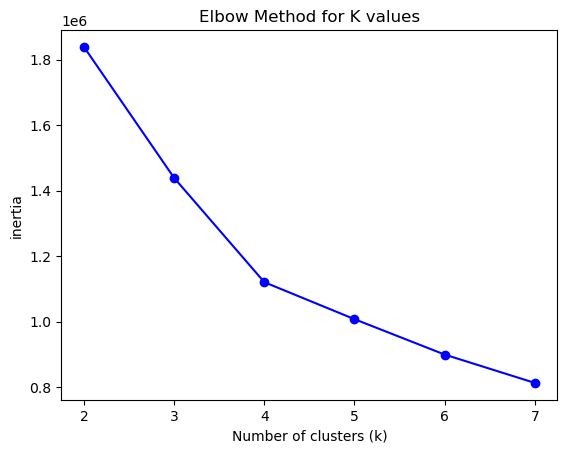

In [24]:
# Plot the elbow curve
plt.plot(range(2, 8), inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('inertia')
plt.title('Elbow Method for K values')
plt.show()

In [25]:
# Choose Cluster 5 based on the elbow method
cluster_summary = stocks.groupby('cluster_5')[num_features].mean().reset_index()
cluster_summary

,cluster_5,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
0,0,0.928660,0.163198,1.143483,0.358298,0.036289,0.195873
1,1,2.451670,0.878046,3.307410,5.145280,1.679028,5.330215
2,2,-0.759240,0.923710,-0.090185,-0.271086,0.312403,-0.215024
3,3,-0.539458,-0.373151,-0.815838,-0.326333,-0.886836,-0.283786
4,4,0.347141,-0.957226,-0.432637,-0.254475,0.119030,-0.256326


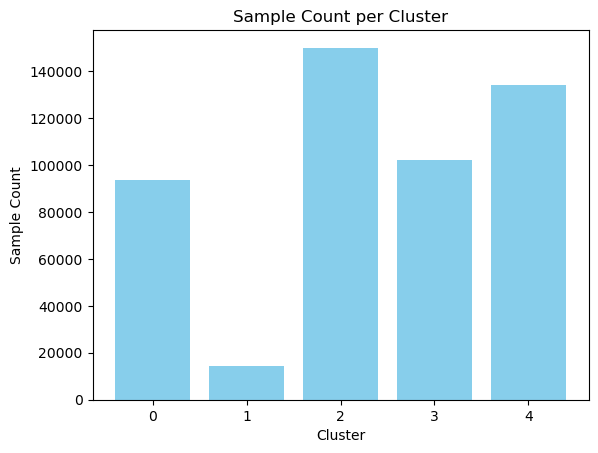

In [26]:
# find the number of samples in eaach cluster
cluster_counts = stocks['cluster_5'].value_counts().sort_index()
cluster_summary['sample_count'] = cluster_counts
plt.bar(cluster_summary['cluster_5'], cluster_summary['sample_count'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Sample Count')
plt.title('Sample Count per Cluster')
plt.xticks(rotation=0)
plt.show()

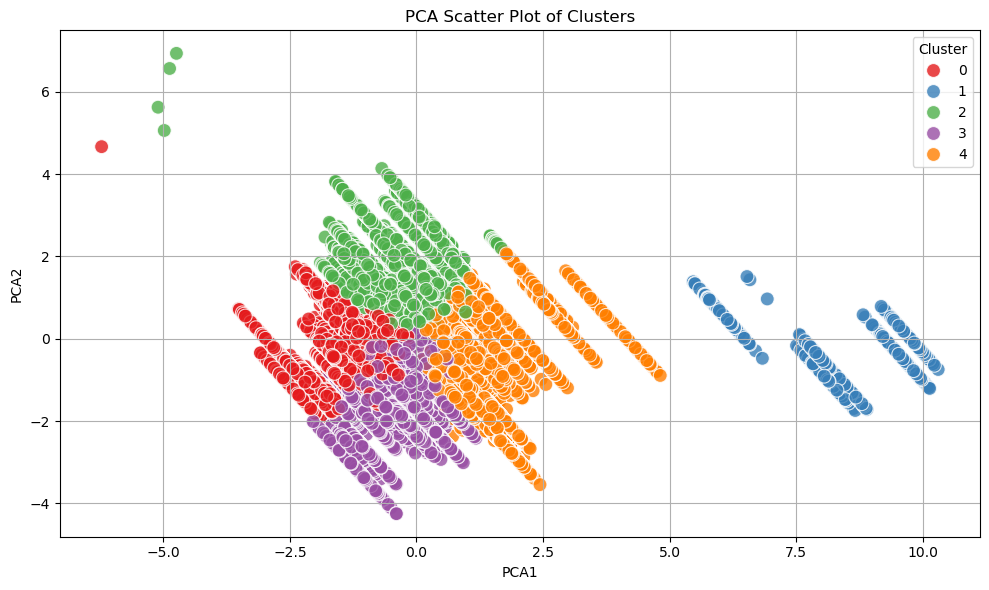

In [ ]:
# Plot PCA Visualization using 'cluster_5' 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=stocks,
    x='PCA1',
    y='PCA2',
    hue='cluster_5',
    palette='Set1',
    s=100,
    alpha=0.8
)

plt.title('PCA Scatter Plot of Stock Clusters (k=5)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

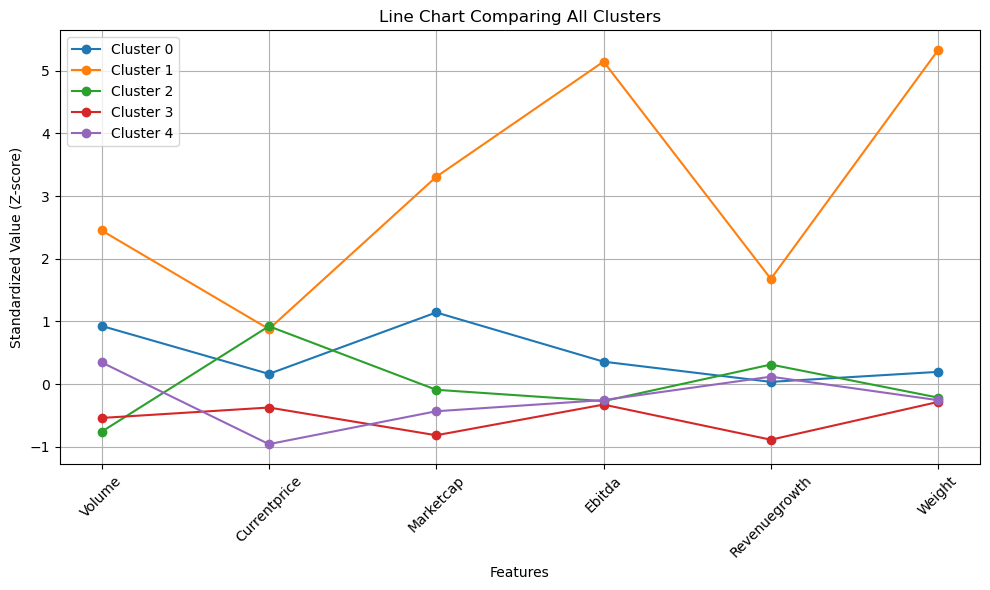

In [27]:
# Plot the mean values of each feature for each cluster
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(num_features, cluster_summary.loc[i, num_features], marker='o', label=f'Cluster {i}')
plt.title('Line Chart Comparing All Clusters')
plt.xlabel('Features')
plt.ylabel('Standardized Value (Z-score)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

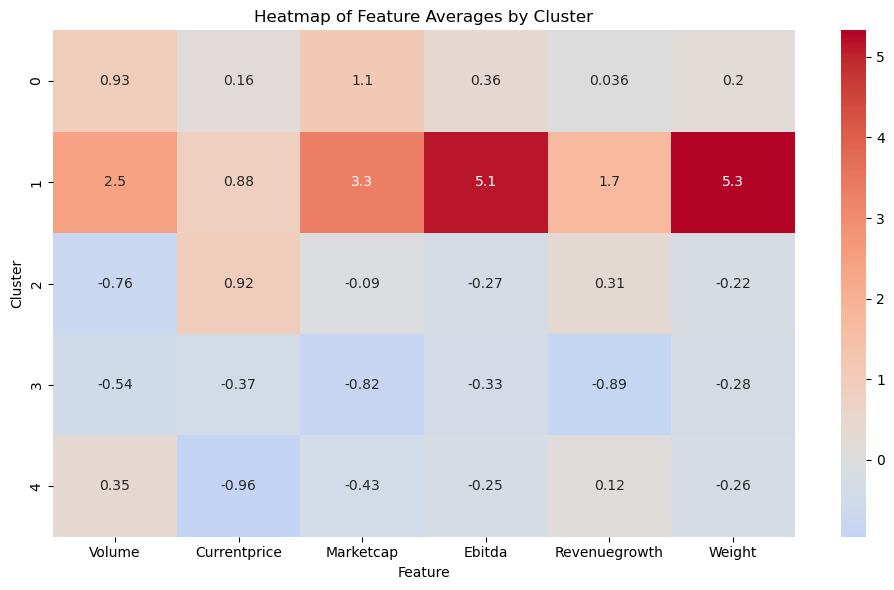

In [28]:
# Heat map of feature averages by cluster
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary[num_features], annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Feature Averages by Cluster')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

## Model Evaluation

In [29]:
stocks_test.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Exchange,Shortname,...,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
426772,2015-02-25,PKG,60.593231,82.099998,82.760002,81.669998,82.639999,585900.0,NYQ,Packaging Corporation of Americ,...,227.98,20473718784,1.625000e+09,0.127,Lake Forest,IL,United States,14900.0,Packaging Corporation of America manufactures ...,0.000368
456261,2012-07-17,PPG,42.514153,52.064999,52.160000,50.959999,51.294998,1810400.0,NYQ,"PPG Industries, Inc.",...,120.21,27888719872,2.870000e+09,-0.015,Pittsburgh,PA,United States,53000.0,"PPG Industries, Inc. manufactures and distribu...",0.000502
239251,2022-08-12,FFIV,172.649994,172.649994,172.880005,170.550003,170.880005,363800.0,NMS,"F5, Inc.",...,252.25,14785608704,7.820980e+08,0.056,Seattle,WA,United States,NaN,"F5, Inc. provides multicloud application secur...",0.000266
50228,2021-10-26,ANSS,376.470001,376.470001,381.220001,375.920013,377.160004,225100.0,NMS,"ANSYS, Inc.",...,338.38,29591330816,8.361090e+08,0.312,Canonsburg,PA,United States,6400.0,"ANSYS, Inc. develops and markets engineering s...",0.000532
296391,2014-09-11,HLT,48.341377,50.971680,51.710400,50.602322,50.889599,3296248.0,NYQ,Hilton Worldwide Holdings Inc.,...,249.42,60803608576,2.457000e+09,0.063,McLean,VA,United States,178000.0,"Hilton Worldwide Holdings Inc., a hospitality ...",0.001094


In [30]:
text_features, num_features, x_test = selectFeatures(stocks_test)  
x_test.head()


,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
426772,PKG,Consumer Cyclical,585900.0,227.98,20473718784,1.625000e+09,0.127,0.000368
456261,PPG,Basic Materials,1810400.0,120.21,27888719872,2.870000e+09,-0.015,0.000502
239251,FFIV,Technology,363800.0,252.25,14785608704,7.820980e+08,0.056,0.000266
50228,ANSS,Technology,225100.0,338.38,29591330816,8.361090e+08,0.312,0.000532
296391,HLT,Consumer Cyclical,3296248.0,249.42,60803608576,2.457000e+09,0.063,0.001094


Removing Duplicate Rows
Number of duplicate rows: 2026
Shape after removing duplicates: (123567, 8)
Imputing missing values by Mean
Imputing missing values by Linear Regression
               total missing  proportion
Symbol                     0         0.0
Sector                     0         0.0
Volume                     0         0.0
Currentprice               0         0.0
Marketcap                  0         0.0
Ebitda                     0         0.0
Revenuegrowth              0         0.0
Weight                     0         0.0
cluster_2                  0         0.0
cluster_3                  0         0.0
cluster_4                  0         0.0
cluster_5                  0         0.0
cluster_6                  0         0.0
cluster_7                  0         0.0
Applying Log Transformation


/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_71617/3201287392.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df.groupby(groupby_col)[feature].transform(lambda x: x.fillna(x.mean()))
/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_71617/3201287392.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.log1p(df[feature])


Normalizing Features


/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_71617/3201287392.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = scaler.fit_transform(df[features])


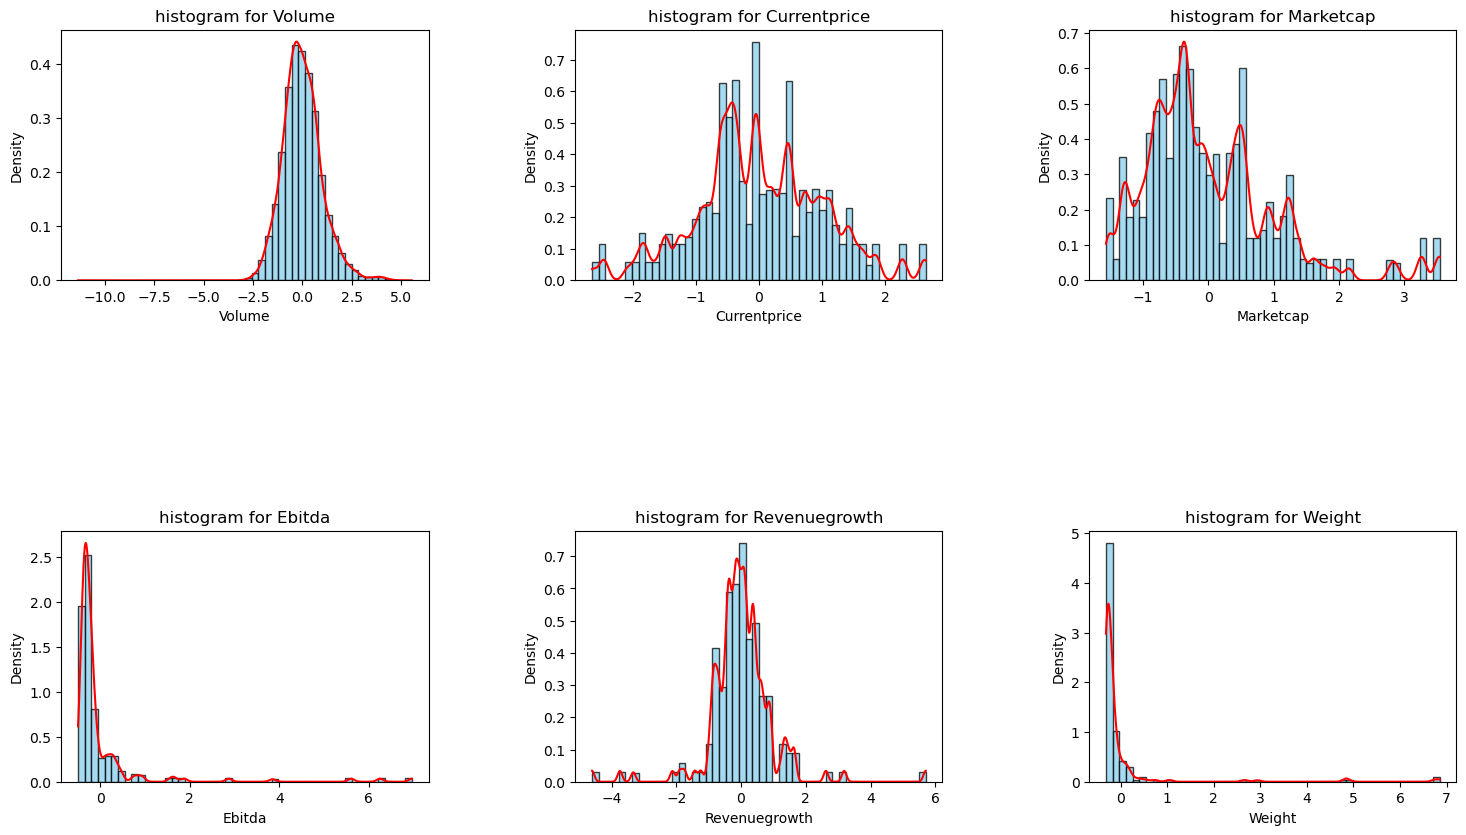

In [31]:
x_test = performFeatureEngineeing(x_test)

In [32]:
x_test

,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
426772,PKG,Consumer Cyclical,-1.170384,0.716319,-0.667175,-0.354878,0.455307,-0.283456
456261,PPG,Basic Materials,-0.304062,-0.000259,-0.412269,-0.288428,-0.592149,-0.266960
239251,FFIV,Technology,-1.536328,0.829805,-0.935612,-0.399866,-0.050801,-0.296111
50228,ANSS,Technology,-1.904970,1.159580,-0.363397,-0.396983,1.637478,-0.263172
296391,HLT,Consumer Cyclical,0.156099,0.817146,0.230542,-0.310471,0.000586,-0.193762
...,...,...,...,...,...,...,...,...
174345,DFS,Financial Services,-0.362518,0.408041,-0.046110,-0.206091,3.205253,-0.232292
476216,PHM,Consumer Cyclical,0.365519,-0.094119,-0.583293,-0.239394,0.392946,-0.278579
314029,INCY,Healthcare,-0.782057,-0.621318,-1.025300,-0.437312,1.185935,-0.299501
451330,PNW,Utilities,-1.009241,-0.387372,-1.286668,-0.336028,0.123987,-0.307516


In [ ]:
# Predict cluster labels for the cleaned test data
test_labels = kmeans.predict(x_test[num_features])

score = silhouette_score(x_test[num_features], test_labels)
print("Silhouette Score on Test:", score)

Silhouette Score on Test: 0.25865465192373754
